# Building Pit

This example demonstrates the modeling of a building pit with dewatering wells using the TimML library. The model calculates groundwater flow towards the pit and evaluates the effectiveness of dewatering strategies by computing total discharge and drawdown distances.

<div class="alert alert-info">

<b>Note</b>

It is highly recommended to use the <code>BuildingPit</code> element if you want to
implement different layer properties inside the building pit as compared to the rest of
the aquifer. Adding barriers, e.g. `LeakyLineDoublets`, around an inhomogeneity will
not work.
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import timml as tml

## Parameters

Define some aquifer parameters 

In [2]:
kh = 2.0  # m/day
f_ani = 1 / 10  # anisotropy factor
kv = f_ani * kh
ctop = 800.0  # resistance top leaky layer in days

Define aquifer top and bottom, the depth of the sheetpile wall and the position of the dewatering wells.

In [3]:
ztop = 0.0  # surface elevation
z_well = -13.0  # end depth of the wellscreen
z_dw = -15.0  # bottom elevation of sheetpile wall
z_extra = z_dw - 15.0  # extra layer
zbot = -60.0  # bottom elevation of the model

Size of the building pit, and the required drawdown at the center of the building pit.

In [4]:
length = 40.0  # length building pit in m
width = 30.0  # width building pit in m

h_bem = -6.21  # m
offset = 5.0  # distance groundwater extraction element from sheetpiles in m

In [5]:
xy = [
    (-length / 2, -width / 2),
    (length / 2, -width / 2),
    (length / 2, width / 2),
    (-length / 2, width / 2),
    (-length / 2, -width / 2),
]

Plot the building pit

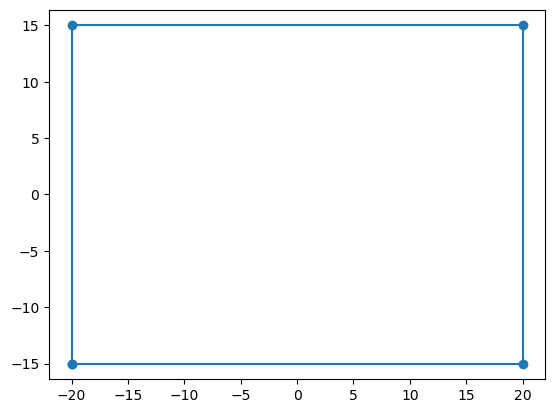

In [6]:
(p2,) = plt.plot(*np.array(xy).T, "o-")
plt.axis("equal")
plt.show()

## Model
Set up a model

In [7]:
z = np.array([ztop + 1, ztop, z_dw, z_dw, z_extra, z_extra, zbot])
dz = z[1::2] - z[2::2]
kh_arr = kh * np.ones(dz.shape)

Resistances of the top confining layer and aquitards

In [8]:
c = np.r_[np.array([ctop]), dz[:-1] / (2 * kv) + dz[1:] / (2 * kv)]

Build model, solve, and calculate total discharge and distance to the 5 cm drawdown contour.

In [9]:
ml = tml.ModelMaq(kaq=kh_arr, z=z, c=c, topboundary="semi", hstar=0.0)

layers = np.arange(np.sum(z_dw <= ml.aq.zaqbot))
last_lay_dw = layers[-1]

inhom = tml.BuildingPitMaq(
    ml,
    xy,
    kaq=kh_arr,
    z=z[1:],
    topboundary="conf",
    c=c[1:],
    order=4,
    ndeg=3,
    layers=layers,
)

tml.River(
    ml,
    x1=-length / 2 + offset,
    y1=width / 2 - offset,
    x2=length / 2 - offset,
    y2=width / 2 - offset,
    hls=h_bem,
    layers=np.arange(last_lay_dw + 1),
)
tml.River(
    ml,
    x1=-length / 2 + offset,
    y1=0,
    x2=length / 2 - offset,
    y2=0,
    hls=h_bem,
    layers=np.arange(last_lay_dw + 1),
)
tml.River(
    ml,
    x1=-length / 2 + offset,
    y1=-width / 2 + offset,
    x2=length / 2 - offset,
    y2=-width / 2 + offset,
    hls=h_bem,
    layers=np.arange(last_lay_dw + 1),
)

# ml.solve_mp(nproc=2)
ml.solve()

Qtot = 0.0

for e in ml.elementlist:
    if e.name == "River":
        Qtot += e.discharge()

print("\nDischarge =", np.round(Qtot.sum(), 2), "m^3/day")

y = np.linspace(-width / 2 - 25, width / 2 + 1100, 201)
hl = ml.headalongline(np.zeros(201), y, layers=[0])
y_5cm = np.interp(
    -0.05, ml.headalongline(np.zeros(201), y, layers=0).squeeze(), y, right=np.nan
)
print("Distance to 5 cm drawdown contour =", np.round(y_5cm, 2), "m")

Number of elements, Number of equations: 21 , 124
....................
solution complete

Discharge = 88.1 m^3/day
Distance to 5 cm drawdown contour = 301.43 m


Plot an overview of the model

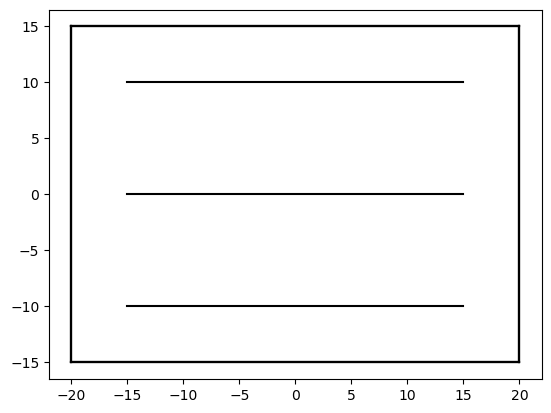

In [10]:
ml.plots.topview()

Visualizations


In [11]:
x = np.linspace(0.0, length / 2 + 1100, 201)
hl = ml.headalongline(x, np.zeros(201), layers=[last_lay_dw, last_lay_dw + 1])

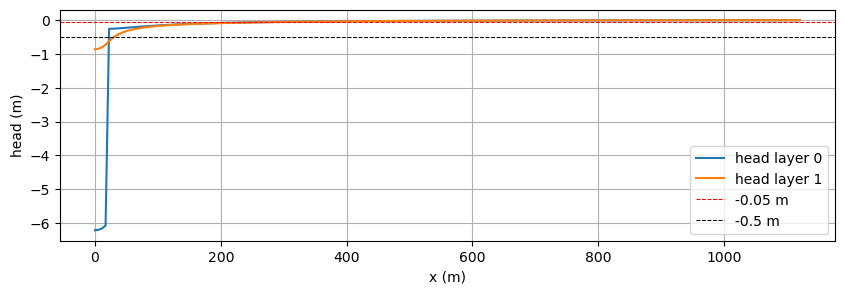

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(x, hl[0].squeeze(), label="head layer {}".format(last_lay_dw))
ax.plot(x, hl[1].squeeze(), label="head layer {}".format(last_lay_dw + 1))
ax.axhline(-0.05, color="r", linestyle="dashed", lw=0.75, label="-0.05 m")
ax.axhline(-0.5, color="k", linestyle="dashed", lw=0.75, label="-0.5 m")
ax.set_xlabel("x (m)")
ax.set_ylabel("head (m)")
ax.legend(loc="best")
ax.grid(True)

In [13]:
x = np.linspace(-length / 2 - 25, 0.0, 201)
hl = ml.headalongline(x, np.zeros(201), layers=[last_lay_dw, last_lay_dw + 1])

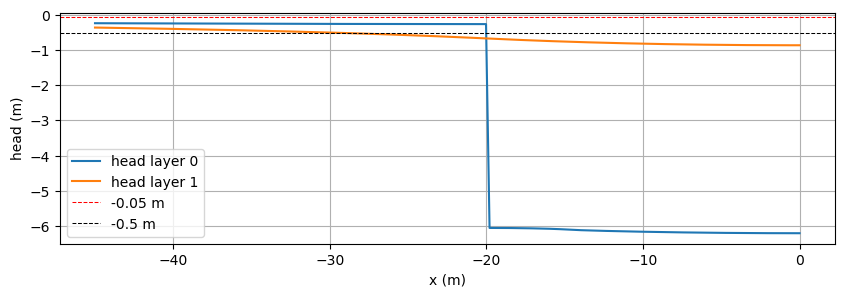

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ax.plot(x, hl[0].squeeze(), label="head layer {}".format(last_lay_dw))
ax.plot(x, hl[1].squeeze(), label="head layer {}".format(last_lay_dw + 1))
ax.axhline(-0.05, color="r", linestyle="dashed", lw=0.75, label="-0.05 m")
ax.axhline(-0.5, color="k", linestyle="dashed", lw=0.75, label="-0.5 m")
ax.set_xlabel("x (m)")
ax.set_ylabel("head (m)")
ax.legend(loc="best")
ax.grid(True)

Plot cross-section around the sheetpile wall

In [15]:
xoffset = 50
zoffset = 15
x1, x2, y1, y2 = [-length / 2 - xoffset, 0.0, 0, 0]
nudge = 1e-6
n = 301

In [16]:
# plot head contour cross-sections
h = ml.headalongline(
    np.linspace(x1 + nudge, x2 - nudge, n),
    np.linspace(y1 + nudge, y2 - nudge, n),
)
L = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
xg = np.linspace(0, L, n) + x1

zg = 0.5 * (ml.aq.zaqbot + ml.aq.zaqtop)
zg = np.hstack((ml.aq.zaqtop[0], zg, ml.aq.zaqbot[-1]))
h = np.vstack((h[0], h, h[-1]))

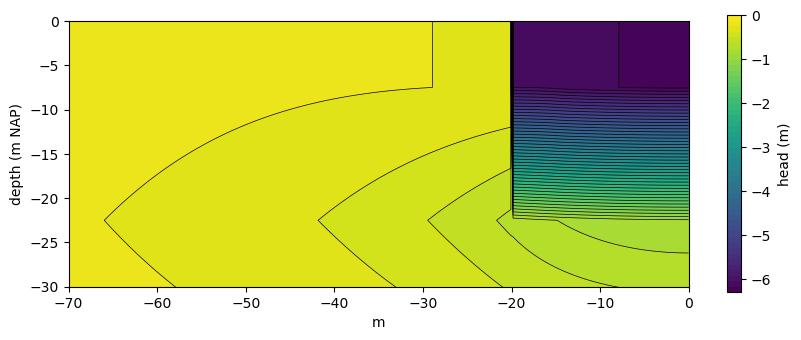

In [17]:
levels = np.linspace(h_bem - 0.1, -0.0, 51)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_aspect("equal")
ml.plots.topview(win=[x1, x2, y1, y2], orientation="ver", newfig=False)
cf = ax.contourf(xg, zg, h, levels)
cs = ax.contour(xg, zg, h, levels, colors="k", linewidths=0.5)
ax.set_ylim(z_dw - zoffset, z_dw + zoffset)
ax.set_ylabel("depth (m NAP)")
ax.set_xlabel("m")

cb = plt.colorbar(cf, ax=ax, shrink=0.6)
cb.set_label("head (m)")
cb.set_ticks(np.arange(-6, 0.1, 1))

## Model 2: Add more layers
Add more layers to the model to get a more accurate solution of the flow towards the building pit.

In [18]:
n = 11  # number of layers around bottom of sheetpile wall

In [19]:
# Calculate thickness of each sublayer above and below the sheetpile wall
dz_i_top = (z_well - z_dw) / np.sum(np.arange(n + 1))
dz_i_bot = (z_dw - z_extra) / np.sum(np.arange(2 * n + 1))

# Generate cumulative depths for sublayers above and below the wall
z_layers_top = np.cumsum(np.arange(n) * dz_i_top)
z_layers_bot = np.cumsum(np.arange(2 * n) * dz_i_bot)

# Combine sublayer depths into a single array for the model
zgr = np.r_[z_dw + z_layers_top[::-1], (z_dw - z_layers_bot)[1:]]

# Build full array of layer boundaries for the model
z4 = np.r_[
    np.array([ztop + 1, ztop, z_well, z_well]),
    np.repeat(zgr, 2, 0),
    z_extra,
    z_extra,
    zbot,
]

# Calculate thicknesses and hydraulic conductivities for each layer
dz4 = z4[1:-1:2] - z4[2::2]
kh_arr = kh * np.ones(dz4.shape)

# Calculate resistance for each layer
c = np.r_[np.array([ctop]), dz4[:-1] / (2 * kv) + dz4[1:] / (2 * kv)]

# Set hydraulic conductivity of the top layer to a very low value
kh_arr2 = kh_arr.copy()
kh_arr2[0] = 1e-5

Build model, solve, and calculate total discharge and distance to the 5 cm drawdown contour.

In [20]:
ml = tml.ModelMaq(kaq=kh_arr, z=z4, c=c, topboundary="semi", hstar=0.0)

layers = np.arange(np.sum(z_dw <= ml.aq.zaqbot))
last_lay_dw = layers[-1]
inhom = tml.BuildingPitMaq(
    ml,
    xy,
    kaq=kh_arr2,
    z=z4[1:],
    topboundary="conf",
    c=c[1:],
    order=4,
    ndeg=3,
    layers=layers,
)

wlayers = np.arange(np.sum(-14 <= ml.aq.zaqbot))
wlayers = wlayers[1:]

tml.River(
    ml,
    x1=-length / 2 + offset,
    y1=width / 2 - offset,
    x2=length / 2 - offset,
    y2=width / 2 - offset,
    hls=h_bem,
    layers=wlayers,
)
tml.River(
    ml,
    x1=-length / 2 + offset,
    y1=0,
    x2=length / 2 - offset,
    y2=0,
    hls=h_bem,
    layers=wlayers,
    order=5,
)
tml.River(
    ml,
    x1=-length / 2 + offset,
    y1=-width / 2 + offset,
    x2=length / 2 - offset,
    y2=-width / 2 + offset,
    hls=h_bem,
    layers=wlayers,
)

# ml.solve_mp(nproc=2)
ml.solve()

Qtot_ml = 0.0

for e in ml.elementlist:
    if e.name == "River":
        Qtot_ml += e.discharge()

print("\nDischarge =", np.round(Qtot_ml.sum(), 2), "m^3/day")

y = np.linspace(-width / 2 - 25, width / 2 + 1100, 201)
hl = ml.headalongline(np.zeros(201), y, layers=[0])
y_5cm_ml = np.interp(
    -0.05, ml.headalongline(np.zeros(201), y, layers=0).squeeze(), y, right=np.nan
)
print("Distance to 5 cm drawdown contour =", np.round(y_5cm_ml, 2), "m")

Number of elements, Number of equations: 21 , 1425
....................
solution complete

Discharge = 210.29 m^3/day
Distance to 5 cm drawdown contour = 500.64 m


In [21]:
last_lay_dw = layers[-1]
x = np.linspace(0.0, length / 2 + 1100, 201)
hl = ml.headalongline(x, np.zeros(201), layers=[0, last_lay_dw, last_lay_dw + 1])

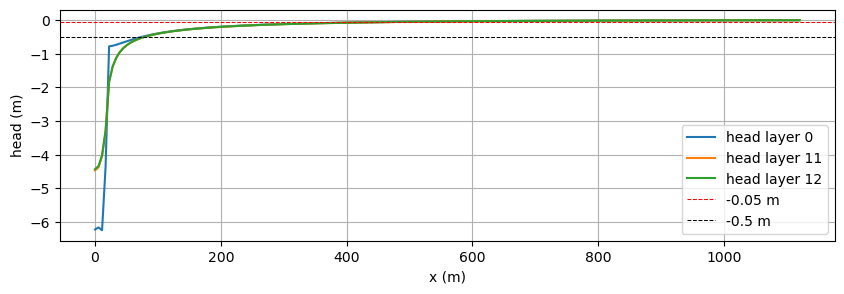

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ax.plot(x, hl[0].squeeze(), label="head layer 0")
ax.plot(x, hl[1].squeeze(), label="head layer {}".format(last_lay_dw))
ax.plot(x, hl[2].squeeze(), label="head layer {}".format(last_lay_dw + 1))
ax.axhline(-0.05, color="r", linestyle="dashed", lw=0.75, label="-0.05 m")
ax.axhline(-0.5, color="k", linestyle="dashed", lw=0.75, label="-0.5 m")
ax.set_xlabel("x (m)")
ax.set_ylabel("head (m)")
ax.legend(loc="best")
ax.grid(True)

In [23]:
x = np.linspace(-length / 2 - 25, 0.0, 201)
hl = ml.headalongline(x, np.zeros(201), layers=[0, last_lay_dw, last_lay_dw + 1])

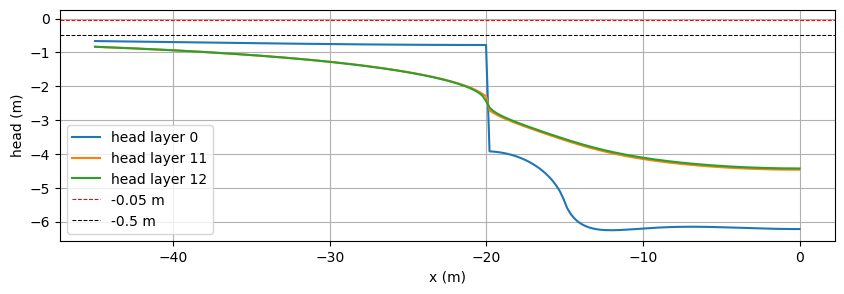

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ax.plot(x, hl[0].squeeze(), label="head layer 0")
ax.plot(x, hl[1].squeeze(), label="head layer {}".format(last_lay_dw))
ax.plot(x, hl[2].squeeze(), label="head layer {}".format(last_lay_dw + 1))
ax.axhline(-0.05, color="r", linestyle="dashed", lw=0.75, label="-0.05 m")
ax.axhline(-0.5, color="k", linestyle="dashed", lw=0.75, label="-0.5 m")
ax.set_xlabel("x (m)")
ax.set_ylabel("head (m)")
ax.legend(loc="best")
ax.grid(True)

Plot head contours in a vertical cross-section around the sheetpile wall.

In [25]:
xoffset = 50
zoffset = 15
x1, x2, y1, y2 = [-length / 2 - xoffset, 0.0, 0, 0]
nudge = 1e-6
n = 301

In [26]:
# plot head contour cross-sections
h = ml.headalongline(
    np.linspace(x1 + nudge, x2 - nudge, n), np.linspace(y1 + nudge, y2 - nudge, n)
)
L = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
xg = np.linspace(0, L, n) + x1

zg = 0.5 * (ml.aq.zaqbot + ml.aq.zaqtop)
zg = np.hstack((ml.aq.zaqtop[0], zg, ml.aq.zaqbot[-1]))
h = np.vstack((h[0], h, h[-1]))

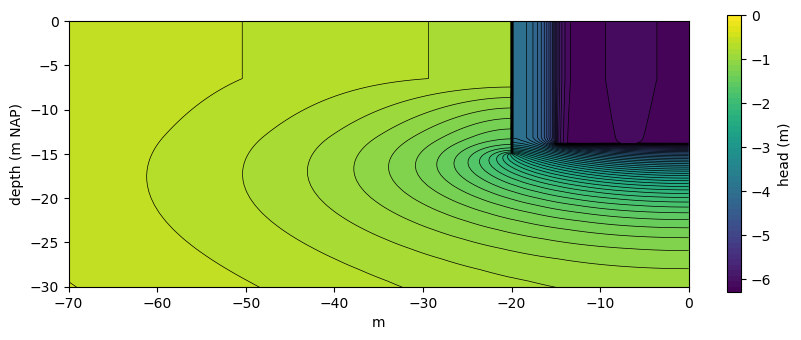

In [27]:
levels = np.linspace(h_bem - 0.1, -0.0, 51)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_aspect("equal")
ml.plots.topview(win=[x1, x2, y1, y2], orientation="ver", newfig=False)
cf = ax.contourf(xg, zg, h, levels)
cs = ax.contour(xg, zg, h, levels, colors="k", linewidths=0.5)
ax.set_ylim(z_dw - zoffset, z_dw + zoffset)
ax.set_ylabel("depth (m NAP)")
ax.set_xlabel("m")

cb = plt.colorbar(cf, ax=ax, shrink=0.6)
cb.ax.set_ylabel("head (m)")
cb.set_ticks(np.arange(-6, 0.1, 1))

Note the difference between the computed discharge between the model with only a few layers and the model with very fine layers.

In [28]:
print("Number of layers                  |  N=3  |  N=35 | unit")
print("-" * 56)
print(
    f"Discharge from building pit       | {Qtot.sum():>5.1f} "
    f"| {Qtot_ml.sum():>5.1f} | m^3/d"
)
print(f"Distance to 5 cm drawdown contour | {y_5cm:>5.1f} | {y_5cm_ml:>5.1f} | m")

Number of layers                  |  N=3  |  N=35 | unit
--------------------------------------------------------
Discharge from building pit       |  88.1 | 210.3 | m^3/d
Distance to 5 cm drawdown contour | 301.4 | 500.6 | m
